In [26]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from mongoengine import *
from urllib.parse import urlparse, parse_qsl
connect('mongoengine_documents')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mongo_classes import *

In [3]:
print(similarity.objects.count())


676711


In [51]:
total_refs = scopus_ref.objects
climate_refs = scopus_ref.objects.filter(text__icontains="climate change")
#climate_refs_n = climate_refs.count()

In [122]:
print(climate_refs.count())

378576


In [123]:
print(scopus_ref.objects.filter(text__icontains="climate change",PY__exists=1).count())
print(scopus_ref.objects.filter(text__icontains="climate change",PY__exists=0).count())

373014
5562


In [5]:
print(total_refs.count())

6264900


In [6]:
print(climate_refs_n)

NameError: name 'climate_refs_n' is not defined

In [5]:
sdocs = scopus_doc.objects
print(sdocs.count())
climate_sdocs = sdocs.filter(TI__icontains="climate change").count()
print(climate_sdocs)

381396
40806


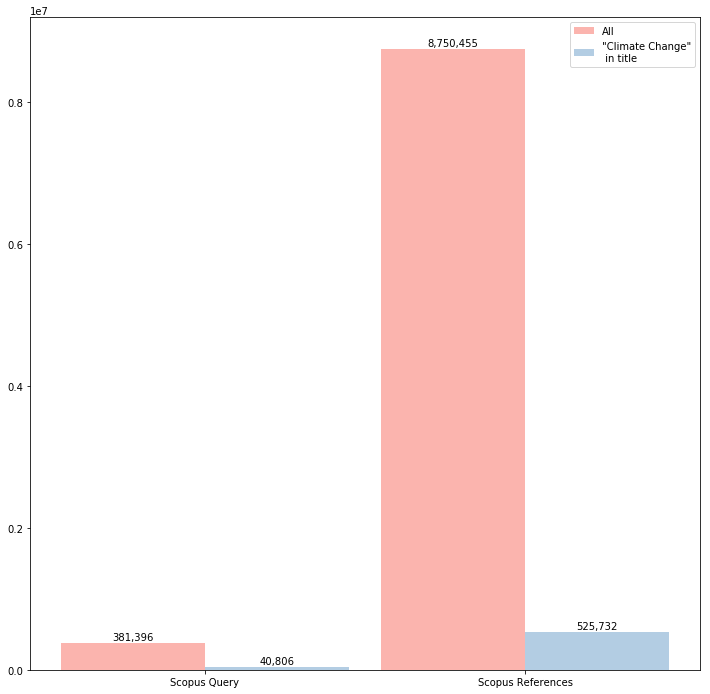

In [38]:
fig_size = [None,None]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

ind = np.arange(2)
ind2 = ind + width
width = 0.45

trefs = [sdocs.count(),total_refs.count()]
crefs = [climate_sdocs,climate_refs_n]

fig,ax = plt.subplots()

p1 = ax.bar(ind,trefs,color='#fbb4ae',width=width)
p2 = ax.bar(ind+width,crefs,color='#b3cde3',width=width)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+10000,
                '%s' % format(int(height),','),
                ha='center', va='bottom')
        
autolabel(p1)
autolabel(p2)

plt.xticks(ind+width/2,('Scopus Query','Scopus References'))
plt.legend((p1[0],p2[0]),('All','"Climate Change"\n in title'))

plt.savefig('../plots/scopus_docs_refs.png',bbox_inches='tight')
plt.show()


In [57]:
pipeline = [
    {"$match": {"PY": {"$exists": 1 }}},
    {"$group" : {"_id":"$PY", "count":{"$sum":1}}}
]
py_results = list(scopus_ref.objects.aggregate(*pipeline))


nopy_results = scopus_doc.objects.filter(PY__exists=0).count()

In [ ]:
pipeline = [
    {"$group" : {"_id":"$PY", "count":{"$sum":1}}}
]
clipy_results = list(scopus_ref.objects.filter(text__icontains="climate change",PY__exists=1).aggregate(*pipeline))

In [71]:
nopy_results = scopus_ref.objects.filter(PY__exists=0).count()
clinopy_results = scopus_ref.objects.filter(text__icontains="climate change",PY__exists=0).count()

In [126]:
pipeline = [
    {"$group" : {"_id":"$PY", "count":{"$sum":1}}}
]
doc_results = list(scopus_doc.objects.aggregate(*pipeline))

In [62]:
pipeline = [
    {"$match": {"TI": {"$regex": ".*climate change.*" }}},
    {"$group" : {"_id":"$PY", "count":{"$sum":1}}}
]
clidoc_results = list(scopus_doc.objects.aggregate(*pipeline))

In [121]:
clinopy_results



5562

      _id  cref_count
0    1895           1
1    1907           1
2    1431           1
3    1853           1
4    5954           1
5    1722           1
6    1876           1
7    2203           1
8    1923           1
9    6455           1
10   1933           1
11   1922           1
12   1959           2
13   1942           1
14   1886           1
15   1860           3
16   5341           1
17   1686           1
18   1857           1
19   1649           1
20   1930           2
21   1834           1
22   1985         134
23   2016         646
24   1919           3
25   2011       15069
26   2010       16564
27   1913           1
28   2002        6387
29   1999        3891
..    ...         ...
94   1948           1
95   1771           1
96   1970          24
97   1961           5
98   1957           5
99   1950           2
100  1945           3
101  1974          11
102  1877           1
103  1943           1
104  1963           7
105  1940           2
106  1968          15
107  1962 

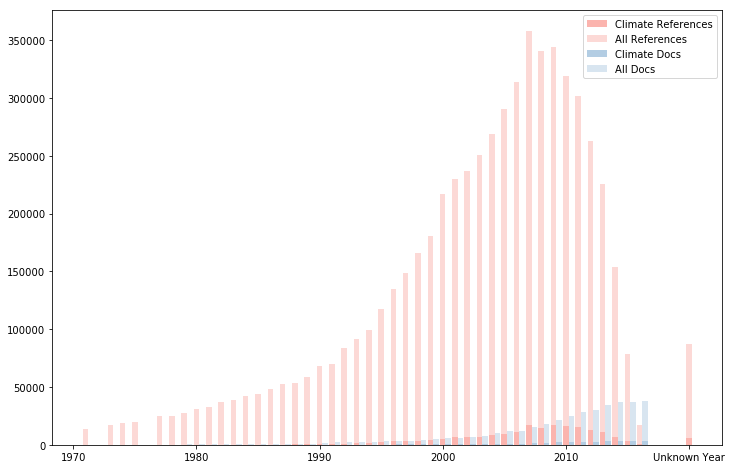

In [125]:
py = pd.DataFrame.from_dict(py_results).rename(index=str,columns={"count": "ref_count"})
cp = pd.DataFrame.from_dict(clipy_results).rename(index=str,columns={"count": "cref_count"})

print(cp)

print(cp.cref_count.sum())

dy = pd.DataFrame.from_dict(doc_results).rename(index=str,columns={"count": "doc_count"})
cdy = pd.DataFrame.from_dict(clidoc_results).rename(index=str,columns={"count": "cdoc_count"})

bad_refs = py[(py['_id']<1800) | (py['_id']>2016)].ref_count.sum()
bad_crefs = cp[(cp['_id']<1800) | (cp['_id']>2016)].cref_count.sum()

other_crefs = cp[(cp['_id']<1990) & (cp['_id']>1800)].cref_count.sum()

print(other_crefs)



py = py.merge(dy).merge(cp).merge(cdy)

py['ncref_count'] = py.apply(lambda x: x['ref_count'] - x['cref_count'],axis=1)
py['ncdoc_count'] = py.apply(lambda x: x['doc_count'] - x['cdoc_count'],axis=1)

    
print(py.head())

py = py[(py['ref_count']>10) & (py['_id']>1970)]


width = 0.45

py = py.sort_values(by='_id', ascending=1).reset_index(drop=True)

fig_size = [None,None]
fig_size[0] = 12 #width
fig_size[1] = 8 #height
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

p0 = ax.bar(py._id,py['cref_count'],color='#fbb4ae',width=width)
p1 = ax.bar(py._id,py['ncref_count'],color='#fbb4ae',width=width,bottom=py['cref_count'],alpha=0.5)
p2 = ax.bar(py._id+width,py['cdoc_count'],color='#b3cde3',width=width)
p3 = ax.bar(py._id+width,py['ncdoc_count'],color='#b3cde3',width=width,bottom=py['cdoc_count'],alpha=0.5)

p4 = ax.bar(2020,nopy_results+bad_refs,color='#fbb4ae',width=width,alpha=0.5)
p4 = ax.bar(2020,clinopy_results+bad_crefs,color='#fbb4ae',width=width)

# Draw the figure so we can change the x ticks
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[-2] = 'Unknown Year'
ax.set_xticklabels(labels)

ax.legend((p0[0],p1[0],p2[0],p3[0]),('Climate References','All References','Climate Docs','All Docs'))
plt.savefig('../plots/scopus_docs_refs_time.png',bbox_inches='tight')
plt.show()